In [240]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Oxygen transfer parameters
k = 3.2e-13 # h^2.5/m^1.5
CL_star = 6e-3/1e-3 # g/m^3

# Enzyme kinetics parameters
KS = 7/1e-3 # g/m^3
KCL = 3e-4/1e-3 # g/m^3

# Yield coefficients
YOS = 5e-3
YPS = 1.5

# Reaction kinetics
def calc_rs(Vm, S, CL):
    return (Vm*S/(KS + S))*(CL/(KCL + CL)) # g/m^3/h

# Substrate consumption
def calc_dSdt(rs):
    return -rs # g/m^3/h

# Change of concentration of oxygen
def calc_dCLdt(KLa, CL, rs):
    return KLa*(CL_star - CL) - YOS*rs # g/m^3/h

# Change of concentration of product
def calc_dPdt(rs):
    return YPS*rs # g/m^3/h

def model(t, y0, G, N, Vm):
    kLA = k*N**3*np.sqrt(G)

    def ODE(t, y):
        S, CL, P = y

        rs = calc_rs(Vm, S, CL)
        
        dSdt = calc_dSdt(rs)
        dCLdt = calc_dCLdt(kLA, CL, rs)
        dPdt = calc_dPdt(rs)

        return [dSdt, dCLdt, dPdt]
    
    # Solve ODE
    sol = solve_ivp(ODE, [t[0], t[-1]], y0, method='Radau', t_eval=t)

    S = sol.y[0]
    CL = sol.y[1]
    P = sol.y[2]

    return S, CL, P

**a) Simulate the model with the parameters given above and assume an aeration rate of $G = 10 \text{ m}^3.\text{h}^{-1}$. Verify that your system is not oxygen limited. Document your findings using a proper plot of systems concentrations.**

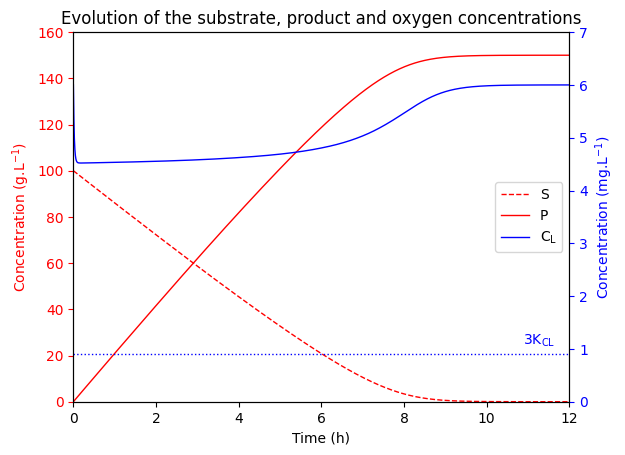

In [241]:
# Initial conditions
y0 = [100/1e-3, 6*1e-3/1e-3, 0] # S, CL, P

# Time points
t = np.linspace(0, 12, 1001)

N = 3e4 # /h
G = 30 # m^3/h
Vm = 16/1e-3 # /m^3/h

# Solve ODE
sol = model(t, y0, G, N, Vm)

S = sol[0] # g/m^3
CL = sol[1] # g/m^3
P = sol[2] # g/m^3

# Plot results
fig, ax1 = plt.subplots()

ax1.plot(t, S/1e3, label='S', color='red', linewidth=1, linestyle='--')
ax1.plot(t, P/1e3, label='P', color='red', linewidth=1)
ax1.set_xlabel('Time (h)')
ax1.set_ylabel(r'Concentration (g.L$^{-1}$)')
ax1.set_xlim(0, t[-1])
ax1.set_ylim(0, 160)

ax1.yaxis.label.set_color('red')
ax1.tick_params(axis='y', colors='red')

ax2 = ax1.twinx()
ax2.plot(t, CL*1e3/1e3, label=r'$\mathregular{C_L}$', color='blue', linewidth=1)
ax2.hlines(3*KCL*1e3/1e3, 0, t[-1], color='blue', linestyle=':', linewidth=1)
ax2.annotate(r'$\mathregular{3K_{CL}}$', (t[-1], KCL*3*1e3/1e3), textcoords="offset points", xytext=(-10, 10), ha='right', va='center', color='blue')
ax2.set_ylabel(r'Concentration (mg.L$^{-1}$)')
ax2.set_ylim(0, 7)

ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')

# Combine the legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='right')  # Combine the legends and set the location to lower right

plt.title('Evolution of the substrate, product and oxygen concentrations')
plt.show()

**b) Find the aeration rate at which the reaction becomes oxygen limited. Plot therefore the minimum dissolved oxygen concentration as a function of the aeration rate.**

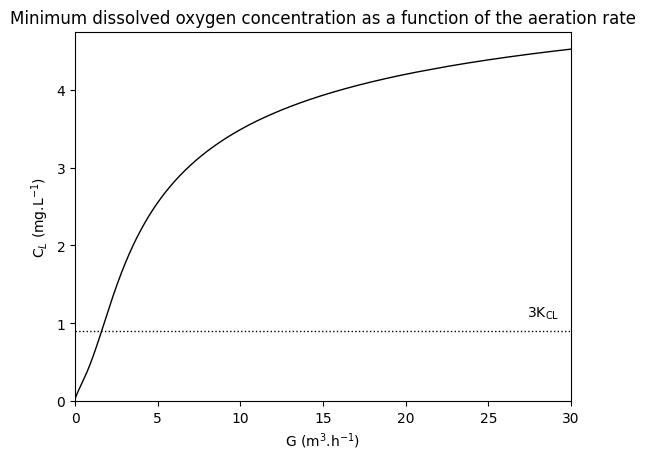

1.6199999999999999


In [242]:
G = np.linspace(0, 30, 1001)
CLmin = np.zeros(len(G))
for i in range(len(G)):
    sol2 = model(t, y0, G[i], N, Vm)
    CL2 = sol2[1]
    CLmin[i] = np.min(CL2)

plt.plot(G, CLmin*1e3/1e3, color='black', linewidth=1)
plt.hlines(3*KCL, 0, G[-1], color='black', linestyles=':', linewidth=1)
plt.annotate(r'$\mathregular{3K_{CL}}$', (G[-1], 3*KCL*1e3/1e3), textcoords="offset points", xytext=(-20, 10), ha='center')
plt.xlabel(r'G (m$^3$.h$^{-1}$)')
plt.ylabel(r'C$_L$ (mg.L$^{-1}$)')
plt.xlim(0, G[-1])
plt.ylim(0)
plt.title('Minimum dissolved oxygen concentration as a function of the aeration rate')
plt.show()

Gmin = G[CLmin >= 3*KCL][0]
print(Gmin)

**c) Set the aeration rate to the value found in b) and reduce the maximum substrate consumption rate $V_m$ by half. Does the average product formation rate (from $t = 0$ till the beginning of the steady-state) decrease by $\frac{1}{2}$ (perform analysis for $V_m = V_m$ and $V_m = \frac{V_m}{2}$). Is the reaction still oxygen limited?**

In [243]:
t = np.linspace(0, 24, 1001)

sol3 = model(t, y0, Gmin, N, Vm)

S3 = sol3[0]
CL3 = sol3[1]
P3 = sol3[2]

rs3 = calc_rs(Vm, S3, CL3)
dP_dt3 = YPS*rs3
prod3 = np.average(dP_dt3[dP_dt3 > 100])

sol4 = model(t, y0, Gmin, N, Vm/2)

S4 = sol4[0]
CL4 = sol4[1]
P4 = sol4[2]

rs4 = calc_rs(Vm/2, S4, CL4)
dP_dt4 = YPS*rs4
prod4 = np.average(dP_dt4[dP_dt4 > 100])

print(prod3, prod4)

12721.135841149995 7294.633635826982


**d) For the 2 values of $V_m$ in c), plot and dicuss the time evolution of the dissolved oxygen concentration.**

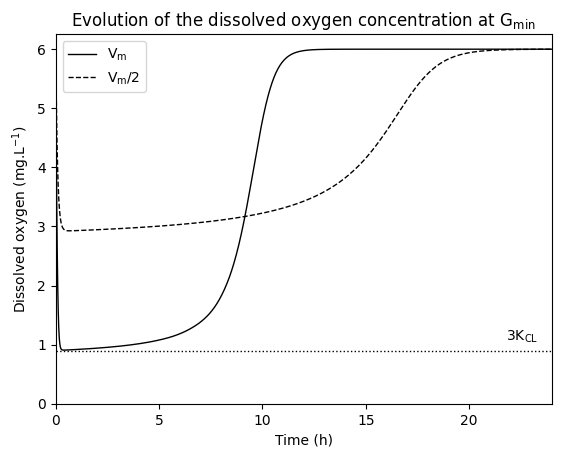

In [244]:
plt.plot(t, CL3, label=r'$\mathregular{V_m}$', color="black", linewidth=1)
plt.plot(t, CL4, label=r'$\mathregular{V_m}/2$', color="black", linewidth=1, linestyle='--')
plt.hlines(3*KCL*1e3/1e3, 0, t[-1], color='black', linestyle=':', linewidth=1)
plt.annotate(r'$\mathregular{3K_{CL}}$', (t[-1], 3*KCL*1e3/1e3), textcoords="offset points", xytext=(-10, 10), ha='right', va='center', color='black')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel(r'Dissolved oxygen (mg.L$^{-1}$)')
plt.title(r'Evolution of the dissolved oxygen concentration at $\mathregular{G_{min}}$')
plt.xlim(0, t[-1])
plt.ylim(0)
plt.show()

**In the oxygen-limited conditions as found in b), decrease $N$ by 15% and comment the change of $k_La$, $C_L$ and $r_S$. Consider the original value of $V_m$.**

10.996924661013187
6.753486357444723


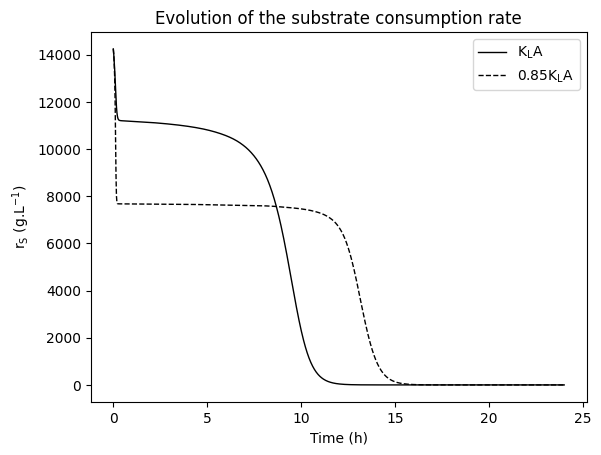

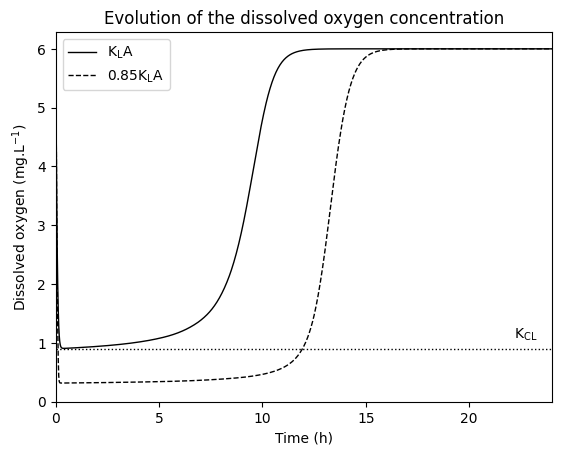

In [245]:
rs3 = Vm*S3/(KS + S3)*(CL3/(KCL + CL3))
kLA3 = k*N**3*np.sqrt(Gmin)
print(kLA3)

kLA5 = k*(0.85*N)**3*np.sqrt(Gmin)
print(kLA5)
sol5 = model(t, y0, Gmin, 0.85*N, Vm)
S5 = sol5[0]
CL5 = sol5[1]
rs5 = Vm*S5/(KS + S5)*(CL5/(KCL + CL5))

plt.plot(t, rs3, label=r'$\mathregular{K_LA}$', color='black', linewidth=1)
plt.plot(t, rs5, label=r'$0.85\mathregular{K_LA}$', color='black', linewidth=1, linestyle='--')
plt.xlabel('Time (h)')
plt.ylabel(r'$\mathregular{r_S}$ (g.L$^{-1}$)')
plt.title('Evolution of the substrate consumption rate')
plt.legend()
plt.show()

plt.plot(t, CL3, label=r'$\mathregular{K_LA}$', color='black', linewidth=1)
plt.plot(t, CL5, label=r'$0.85\mathregular{K_LA}$', color='black', linewidth=1, linestyle='--')
plt.hlines(3*KCL*1e3/1e3, 0, t[-1], color='black', linestyle=':', linewidth=1)
plt.annotate(r'$\mathregular{K_{CL}}$', (t[-1], 3*KCL*1e3/1e3), textcoords="offset points", xytext=(-10, 10), ha='right', va='center', color='black')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel(r'Dissolved oxygen (mg.L$^{-1}$)')
plt.title('Evolution of the dissolved oxygen concentration')
plt.xlim(0, t[-1])
plt.ylim(0)
plt.show()

**Find 5 combinaisons of N and G so that you achieve non-oxygen limiting conditions, justify your choices. Plot the variation in the product formation curves for each case. Discuss the effect of N and G on product formation.**

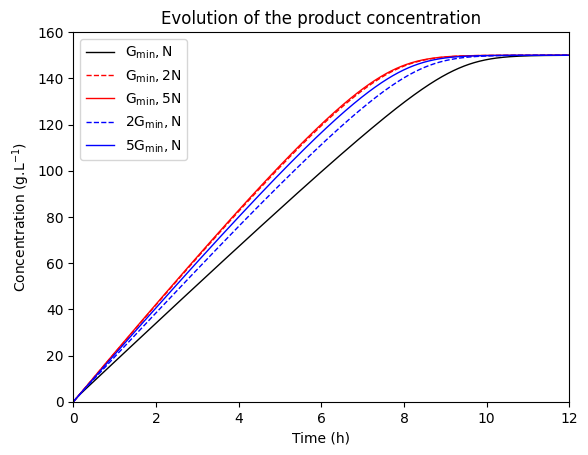

In [246]:
t = np.linspace(0, 12, 1001)

sol6 = model(t, y0, Gmin, N, Vm)
sol7 = model(t, y0, Gmin, 2*N, Vm)
sol8 = model(t, y0, Gmin, 5*N, Vm)
sol9 = model(t, y0, 2*Gmin, N, Vm)
sol10 = model(t, y0, 5*Gmin, N, Vm)

P6 = sol6[2]
P7 = sol7[2]
P8 = sol8[2]
P9 = sol9[2]
P10 = sol10[2]

plt.plot(t, P6/1e3, label=r'$\mathregular{G_{min}, N}$', color='black', linewidth=1)
plt.plot(t, P7/1e3, label=r'$\mathregular{G_{min}, 2N}$', color='red', linewidth=1, linestyle='--')
plt.plot(t, P8/1e3, label=r'$\mathregular{G_{min}, 5N}$', color='red', linewidth=1)
plt.plot(t, P9/1e3, label=r'$\mathregular{2G_{min}, N}$', color='blue', linewidth=1, linestyle='--')
plt.plot(t, P10/1e3, label=r'$\mathregular{5G_{min}, N}$', color='blue', linewidth=1)
plt.xlabel('Time (h)')
plt.xlim(0, t[-1])
plt.ylim(0, 160)
plt.ylabel(r'Concentration (g.L$^{-1}$)')
plt.title('Evolution of the product concentration')

plt.legend()

plt.show()